In [ ]:
# Dataframes
import pandas as pd

# Array
import numpy as np

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import preprocessing


# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

: 

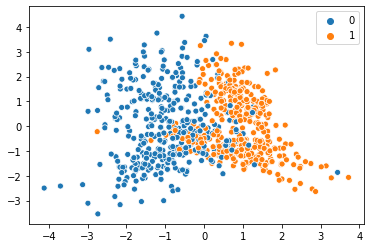

In [36]:
# Import dataset
X,y=make_classification(n_samples=750,n_features=2,n_redundant=0,n_informative=2,n_clusters_per_class=2,random_state=1)
df=pd.DataFrame(dict(x=X[:,0],y=X[:,1],label=y))
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y)

In [37]:
df.describe()

,x,y,label
count,750.000000,750.000000,750.000000
mean,-0.038960,0.019236,0.496000
std,1.265745,1.373707,0.500318
min,-4.121713,-3.535973,0.000000
25%,-1.040204,-1.065453,0.000000
50%,0.026298,-0.209334,0.000000
75%,0.944501,1.083736,1.000000
max,3.722419,4.429521,1.000000


In [44]:
scaler = preprocessing.MinMaxScaler()
d=scaler.fit_transform(df)
scaled_df=pd.DataFrame(d,columns=df.columns)
scaled_df.head()

,x,y,label
0,0.448595,0.738559,0.0
1,0.384053,0.175101,0.0
2,0.464405,0.201234,0.0
3,0.621193,0.604585,1.0
4,0.390659,0.240175,0.0


In [45]:
scaled_df.describe()

,x,y,label
count,750.000000,750.000000,750.000000
mean,0.520485,0.446326,0.496000
std,0.161362,0.172457,0.500318
min,0.000000,0.000000,0.000000
25%,0.392842,0.310153,0.000000
50%,0.528804,0.417631,0.000000
75%,0.645860,0.579965,1.000000
max,1.000000,1.000000,1.000000


In [46]:
# Split train and test
X=scaled_df[['x','y']]
y=scaled_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [48]:
sns.histplot(data=scaled_df,x='x')

AttributeError: module 'seaborn' has no attribute 'histplot'